In [1]:
#!pip install matplotlib

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def quantize_pixel(pixel, n_colours):
    k = int(n_colours ** (1/3))
    factor = int(256 / k)
    return [int(pixel[0]/factor), int(pixel[1]/factor), int(pixel[2]/factor)]

def get_color_number_from_pixel(pixel, n_colours):
    k = int(n_colours ** (1/3))
    return k * k * pixel[0] + k * pixel[1] + pixel[2]

def convert_quantized_image_to_visualize(quantized_img, n_colours):
    k = int(n_colours ** (1/3))
    factor = int(256 / k)
    final_image = []
    for pixel in quantized_img.reshape(-1, 3):
        final_image.append([int(pixel[0] * factor), int(pixel[1] * factor), int(pixel[2] * factor)])
    final_image_np = np.asarray(final_image)
    final_image_np = final_image_np.reshape(quantized_img.shape)
    return final_image_np

def get_preprocessed_image(image, n_colours):
    # Blur the image
    blurred_image = cv2.blur(image, (3, 3))
    quantized_image = []
    for pixel in blurred_image.reshape(-1, 3):
        quantized_image.append(quantize_pixel(pixel, n_colours))
    quantized_image_np = np.asarray(quantized_image)
    quantized_image_np = quantized_image_np.reshape(image.shape)
    return quantized_image_np

def get_colour_mask_from_quantized_image(quantized_image, n_colours):
    color_mask = []
    for pixel in quantized_image.reshape(-1, 3):
        color_mask.append(get_color_number_from_pixel(pixel, n_colours))
    return np.asarray(color_mask)

def get_histo_masks(image):
    height, width, c = image.shape
    
    # Define the region to keep (central 75%)
    h_start = int(0.125 * height)
    h_end = int(0.875 * height)
    w_start = int(0.125 * width)
    w_end = int(0.875 * width)

    # Create a binary mask
    central_mask = np.zeros((height, width), dtype=np.uint8)
    central_mask[h_start : h_end, w_start : w_end] = 255
    peripheral_mask = ~central_mask

    # Plot the original image and the masked image
#     plt.subplot(1, 2, 1)
#     plt.title("Original Image")
#     plt.imshow(image, cmap='gray')

#     plt.subplot(1, 3, 2)
#     plt.title("Central Mask")
#     plt.imshow(central_mask, cmap='gray')

#     plt.subplot(1, 3, 3)
#     plt.title("Peripheral Image")
#     plt.imshow(peripheral_mask, cmap='gray')

#     plt.show()
    
    return central_mask, peripheral_mask

### The Three Measures

In [22]:
## Basic Color Histograms

def compare_basic_histograms(img1, img2, bins):
    # Calculate histograms
    channel_bins = [bins, bins, bins]
    ranges = [0, 256, 0, 256, 0, 256]
    hist_img1 = cv2.calcHist([img1], [0, 1, 2], None, channel_bins, ranges)
    hist_img2 = cv2.calcHist([img2], [0, 1, 2], None, channel_bins, ranges)
    
    #Just to show
    plt.plot(hist_img1.ravel())
    plt.xlim([0,bins**3])
    plt.show()
    
    plt.plot(hist_img2.ravel())
    plt.xlim([0,bins**3])
    plt.show()

    # Normalize histograms
    cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    # Distances
    corr = np.corrcoef(hist_img1.ravel(), hist_img2.ravel())[0, 1]
    l1 = np.sum(np.abs(hist_img1.ravel() - hist_img2.ravel()))
    l2 = np.sqrt(np.sum((hist_img1.ravel() - hist_img2.ravel())**2))
    return np.abs(corr), l1, l2

In [23]:
### Split Histograms

def compare_split_histograms(img1, img2, bins):
    
    # Calculate histograms
    channel_bins = [bins, bins, bins]
    ranges = [0, 256, 0, 256, 0, 256]
    
    # Get masks
    central_mask_1, peripheral_mask_1 = get_histo_masks(img1)
    central_mask_2, peripheral_mask_2 = get_histo_masks(img2)
    
    # Compute Central Histograms
    central_hist_img1 = cv2.calcHist([img1], [0, 1, 2], central_mask_1, channel_bins, ranges)
    central_hist_img2 = cv2.calcHist([img2], [0, 1, 2], central_mask_2, channel_bins, ranges)
    
    # Compute Peripheral Histograms
    peripheral_hist_img1 = cv2.calcHist([img1], [0, 1, 2], peripheral_mask_1, channel_bins, ranges)
    peripheral_hist_img2 = cv2.calcHist([img2], [0, 1, 2], peripheral_mask_2, channel_bins, ranges)
    
    #Just to show
    plt.plot(central_hist_img1.ravel())
    plt.xlim([0,bins**3])
    plt.show()
    
    plt.plot(peripheral_hist_img1.ravel())
    plt.xlim([0,bins**3])
    plt.show()

    # Normalize histograms
    cv2.normalize(central_hist_img1, central_hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(central_hist_img2, central_hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(peripheral_hist_img1, peripheral_hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(peripheral_hist_img2, peripheral_hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

    # Distances
       # Distances
    corr = np.corrcoef(central_hist_img1.ravel(), central_hist_img2.ravel())[0, 1] + np.corrcoef(peripheral_hist_img1.ravel(), peripheral_hist_img2.ravel())[0, 1]
    l1 = np.sum(np.abs(central_hist_img1.ravel() - central_hist_img2.ravel())) + np.sum(np.abs(peripheral_hist_img1.ravel() - peripheral_hist_img2.ravel()))
    l2 = np.sqrt(np.sum((central_hist_img1.ravel() - central_hist_img2.ravel())**2)) + np.sqrt(np.sum((peripheral_hist_img1.ravel() - peripheral_hist_img2.ravel())**2))
    return np.abs(corr/2), l1/2, l2/2

In [43]:
### Color Coherence Vectors

def get_ccv_from_quantized_image(image, channel_bins, tau):
    n_colours = channel_bins ** 3
    quantized_image = get_preprocessed_image(image, n_colours)
    # Initialize coherence vector
    ccv_vector = []
    # Get color mask from quantized image
    colour_mask = get_colour_mask_from_quantized_image(quantized_image, n_colours)
    shaped_colour_mask = colour_mask.reshape(quantized_image.shape[0], quantized_image.shape[1])

    # Iterate over each discretized color
    for i in range(n_colours):
        # Extract pixels with the current color
        binary_mask = (shaped_colour_mask == i).astype(np.uint8)
        # Find connected components
        _, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=4)
        # Initialize coherence pair
        alpha_j, beta_j = 0, 0
        # Iterate over connected components
        for j in range(1, stats.shape[0]):
            component_size = stats[j, cv2.CC_STAT_AREA]
            # Classify pixels as coherent or incoherent based on the size
            if component_size > tau:
                alpha_j += component_size
            else:
                beta_j += component_size
        # Add coherence pair to the vector
        ccv_vector.append(alpha_j)
        ccv_vector.append(beta_j)
    return np.asarray(ccv_vector)

def compare_ccvs(img1, img2, channel_bins, tau):
    ccv1 = get_ccv_from_quantized_image(img1, channel_bins, tau)
    #Just to show
    plt.plot(ccv1.ravel())
    plt.xlim([0,len(ccv1)])
    plt.show()
    ccv2 = get_ccv_from_quantized_image(img2, channel_bins, tau)
    ccv1 = (ccv1 - np.min(ccv1)) / (np.max(ccv1) - np.min(ccv1))
    ccv2 = (ccv2 - np.min(ccv2)) / (np.max(ccv2) - np.min(ccv2))
    l1 = np.sum(np.abs(ccv1 - ccv2))
    l2 = np.sqrt(np.sum((ccv1 - ccv2)**2))
    corr = np.corrcoef(ccv1, ccv2)[0, 1]
    return np.abs(corr), l1, l2

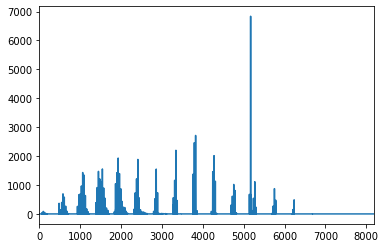

Correlation Coefficient: 1.0
L1 Distance: 0.0
L2 Distance: 0.0


In [44]:
# Example usage
image1_path = '/home/dhruv/Projects/CBIR/dataset/training_set/mountains_and_snow/882.jpg'
image2_path = '/home/dhruv/Projects/CBIR/dataset/training_set/mountains_and_snow/882.jpg'

# Read images
img1 = cv2.imread(image1_path)
img2 = cv2.imread(image2_path)

# Preprocess images
channel_bins = 16
#n_colours = channel_bins ** 3

#correlation, l1, l2 = compare_basic_histograms(img1, img2, channel_bins)
#correlation, l1, l2 = compare_split_histograms(img1, img2, channel_bins)
correlation, l1, l2 = compare_ccvs(img1, img2, channel_bins, 300)

print(f"Correlation Coefficient: {correlation}")
print(f"L1 Distance: {l1}")
print(f"L2 Distance: {l2}")

### Top K Retrieval

In [7]:
import os
import cv2
import numpy as np
import operator
import tqdm
import glob

In [8]:
def load_images_from_folder(folder_path):
    images = []
    labels = []
    for subfolder_name in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder_name)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                images.append(img_path)
                labels.append(subfolder_name)
    return images, labels

In [9]:
def display_images(query_image, matched_image_path, proximity_value):
    # Display query image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
    plt.title("Query Image")

    # Display top match image
    plt.subplot(1, 2, 2)
    matched_image = cv2.imread(matched_image_path)
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Matched with value: {proximity_value:.4f}")
    plt.show()

In [10]:
def process_query_image(query_image_path, images, distribution = 'basic-histogram', proximity = 'l2', channel_bins = 8):
    # Read the query image
    query_image = cv2.imread(query_image_path)

    # Compare the query image with each image from set of images
    results = []
    for image in tqdm.tqdm(images):
        candidate_image = cv2.imread(image)
        if distribution == 'split-histogram':
                corr, l1, l2 = compare_split_histograms(query_image, candidate_image, channel_bins)
        elif distribution == 'ccv':
                corr, l1, l2 = compare_ccvs(query_image, candidate_image, channel_bins, 300)
        else:
            corr, l1, l2 = compare_basic_histograms(query_image, candidate_image, channel_bins)
        entry = {}
        entry['image-name'] = image
        entry['l1'] = l1
        entry['l2'] = l2
        entry['corr'] = corr
        results.append(entry)
        

    # Sort the images based on proximity
    reverse = False
    if proximity == 'corr':
        reverse = True
    results.sort(key=lambda d: d[proximity], reverse = reverse)
    return results

In [11]:
def perform_eval(query_image_path, images, labels, results):
    label_dict= {}
    actual_label = query_image_path.split('/')[-2:][0]
    assert len(labels) == len(images)
    total_gts = 0
    total_det = len(results)
    for i in range(len(labels)):
        label_dict[images[i]] = labels[i]
        if labels[i] == actual_label:
            total_gts = total_gts + 1
    tp = 0
    for entry in results:
        image_name = entry['image-name']
        detected_label = image_name.split('/')[-2:][0]
        if detected_label == actual_label:
            tp = tp + 1
    
    p = tp / total_det if total_det else 0 
    r = tp / total_gts if total_gts else 0
    f = 2 * p * r / (p + r) if (p > 0 and r > 0) else 0
    return p, r, f

In [12]:
def run_query(dataset_path, query_image_path, distribution, proximity, channel_bins, k,
              display_results = True, experimentation = False):

    # Load images and labels
    images, labels = load_images_from_folder(dataset_path)

    # Process the query image
    results = process_query_image(query_image_path, images, distribution, proximity, channel_bins)
    
    # Filter top K results
    if k < len(results):
        results = results[:k]
    
    # Display the results
    if display_results:
        print(f"Query image: {query_image_path}")
        print("Top similar images in the training set:")
        for i in range(len(results)):
            entry = results[i]
            print(f"{distribution} using {proximity} : {entry[proximity]:.4f}")
            # Display images
            display_images(cv2.imread(query_image_path), entry['image-name'], entry[proximity])
    
    # Experimentation to report p, r, f
    p = 0
    r = 0
    f = 0
    if experimentation and len(labels):
        p, r, f = perform_eval(query_image_path, images, labels, results)
#         print(f'Precision : {p:.4f}')
#         print(f'Recall    : {r:.4f}')
#         print(f'F1 Score  : {f:.4f}')
    return p, r, f 

In [35]:
def run_experiment():
    
    # Set your input parameters
    dataset_path = "../dataset/training_set/"
    query_images_path = "../dataset/test_set_small/peolpe_and_villages_in_Africa0.104/"
    distribution = 'ccv'
    proximity = 'l2'
    channel_bins = 16
    k = 25
    
    query_images = glob.glob(query_images_path + '/*.jpg')
    total_p = 0
    total_r = 0
    total_f = 0
    total_q = len(query_images)
    
    for query_image_path in tqdm.tqdm(query_images):
        p, r, f = run_query(dataset_path, query_image_path, distribution, proximity, 
                        channel_bins, k, display_results = False, experimentation = True)
        total_p = total_p + p
        total_r = total_r + r
        total_f = total_f + f
    
    print(f'Precision : {total_p/total_q:.3f}')
    print(f'Recall    : {total_r/total_q:.3f}')
    print(f'F1 Score  : {total_f/total_q:.3f}')

In [36]:
run_experiment()

 17%|█▋        | 155/900 [04:10<20:42,  1.67s/it]


 34%|███▍      | 309/900 [08:31<16:43,  1.70s/it]


 51%|█████▏    | 463/900 [12:49<12:28,  1.71s/it]


 69%|██████▊   | 617/900 [17:20<12:32,  2.66s/it]


 86%|████████▌ | 771/900 [25:08<06:41,  3.11s/it]


100%|██████████| 1/1 [31:38<00:00, 1898.28s/it]

Precision : 0.520
Recall    : 0.144
F1 Score  : 0.226
